In [1]:
from kubernetes import client, config
import pandas as pd
import matplotlib.pyplot as plt

from prometheus_api_client import PrometheusConnect

from datetime import datetime, timedelta
from difflib import diff_bytes
import matplotlib.pyplot as plt

In [2]:
class ElementChain:
    def __init__(self, upStream_pod, downStream_pod, frequency):
        self.upStream_pod = upStream_pod
        self.downStream_pod = downStream_pod
        self.frequency = frequency
    
    def __repr__(self):
        return f"<{self.upStream_pod}, {self.downStream_pod}, {self.frequency}>"
from collections import defaultdict

class CriticalChainAnalysis:
    def __init__(self, element_chains):
        self.element_chains = element_chains
        self.chain_graph = defaultdict(list)
        self._build_graph()

    def _build_graph(self):
        for chain in self.element_chains:
            self.chain_graph[chain.upStream_pod].append((chain.downStream_pod, chain.frequency))

    def _find_all_paths(self, start_pod, end_pod, path=[], frequency_sum=0, count=0):
        path = path + [start_pod]
        if start_pod == end_pod:
            return [(path, frequency_sum/count if count > 0 else 0)]
        if start_pod not in self.chain_graph:
            return []
        paths = []
        for node, freq in self.chain_graph[start_pod]:
            if node not in path:
                newpaths = self._find_all_paths(node, end_pod, path, frequency_sum + freq, count + 1)
                for newpath in newpaths:
                    paths.append(newpath)
        return paths

    def find_longest_critical_path(self):
        # Assuming the start_pod and end_pod are known for simplification
        # This can be adapted to dynamically find all start and end points
        start_pods = set(self.chain_graph.keys())
        end_pods = set([chain.downStream_pod for chain in self.element_chains]) - start_pods

        all_paths = []
        for start_pod in start_pods:
            for end_pod in end_pods:
                all_paths.extend(self._find_all_paths(start_pod, end_pod))

        # Sort by average frequency to find the critical path
        critical_path = sorted(all_paths, key=lambda x: x[1], reverse=True)
        return critical_path

    def __repr__(self):
        return f"Critical Chain Analysis with {len(self.element_chains)} element chains"

# Define element chains
# element_chains = [
#     ElementChain("pod1", "pod2", 4.2), ElementChain("pod1", "pod4", 6.1), ElementChain("pod1", "pod6", 7),
#     ElementChain("pod2", "pod3", 7), ElementChain("pod2", "pod4", 6.1),
#     ElementChain("pod3", "pod7", 6.1), ElementChain("pod3", "pod9", 6.1),
#     ElementChain("pod7", "pod9", 11)
# ]

# # Analyze critical chains
# analysis = CriticalChainAnalysis(element_chains)
# critical_path = analysis.find_longest_critical_path()

# # Display the longest critical path(s) and their average frequency
# print("Critical Path(s):")
# for path, avg_freq in critical_path:
#     print(f"Path: {'->'.join(path)}, Average Frequency: {avg_freq}")



Critical Path(s):
Path: pod7->pod9, Average Frequency: 11.0
Path: pod3->pod7->pod9, Average Frequency: 8.55
Path: pod2->pod3->pod7->pod9, Average Frequency: 8.033333333333333
Path: pod1->pod2->pod3->pod7->pod9, Average Frequency: 7.074999999999999
Path: pod1->pod6, Average Frequency: 7.0
Path: pod2->pod3->pod9, Average Frequency: 6.55
Path: pod1->pod4, Average Frequency: 6.1
Path: pod2->pod4, Average Frequency: 6.1
Path: pod3->pod9, Average Frequency: 6.1
Path: pod1->pod2->pod3->pod9, Average Frequency: 5.766666666666666
Path: pod1->pod2->pod4, Average Frequency: 5.15


[{'metric': {'__name__': 'up', 'app': 'details', 'instance': '192.168.231.237:15020', 'job': 'kubernetes-pods', 'namespace': 'default', 'pod': 'details-v1-5f4d584748-qxkjj', 'pod_template_hash': '5f4d584748', 'security_istio_io_tlsMode': 'istio', 'service_istio_io_canonical_name': 'details', 'service_istio_io_canonical_revision': 'v1', 'version': 'v1'}, 'value': [1711625015.893, '1']}, {'metric': {'__name__': 'up', 'app': 'istio-egressgateway', 'chart': 'gateways', 'heritage': 'Tiller', 'install_operator_istio_io_owning_resource': 'unknown', 'instance': '192.168.231.238:15020', 'istio': 'egressgateway', 'istio_io_rev': 'default', 'job': 'kubernetes-pods', 'namespace': 'istio-system', 'operator_istio_io_component': 'EgressGateways', 'pod': 'istio-egressgateway-687cb674fc-sbsw5', 'pod_template_hash': '687cb674fc', 'release': 'istio', 'service_istio_io_canonical_name': 'istio-egressgateway', 'service_istio_io_canonical_revision': 'latest', 'sidecar_istio_io_inject': 'false'}, 'value': [17

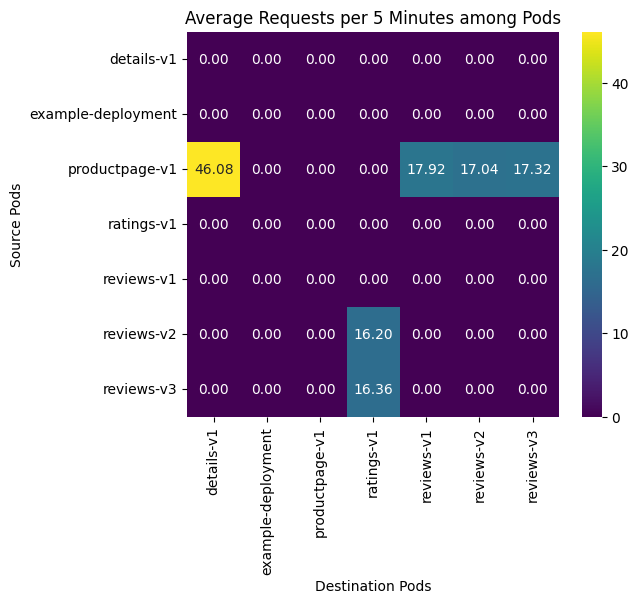

In [7]:
from kubernetes import client, config
import pandas as pd
import matplotlib.pyplot as plt

from prometheus_api_client import PrometheusConnect

from datetime import datetime, timedelta
from difflib import diff_bytes
import matplotlib.pyplot as plt
from regex import E
import seaborn as sns


# Kubernetes Config
config.load_kube_config()
v1 = client.CoreV1Api()

# Prometheus Config
#prom_url = "http://<PROMETHEUS_SERVER_IP>:<PORT>"
# prom_url = "http://10.110.188.57:9090"
prom_url = "http://10.105.116.175:9090"

prom = PrometheusConnect(url=prom_url, disable_ssl=True)
#test prom connection
prom_connect_response = prom.custom_query(query="up")
print(prom_connect_response)


from datetime import datetime, timedelta

def transmitted_req_calculator(workload_src, workload_dst, timerange, step_interval):
    # Define the end time as now
    end_time = datetime.now() - timedelta(minutes=60*9)
    # Define the start time as 'timerange' minutes before the end time
    start_time = end_time - timedelta(minutes=timerange)

    # Define the istio request query
    istio_req_query = f'istio_requests_total{{reporter="source",source_workload="{workload_src}",destination_workload="{workload_dst}",response_code="200"}}'
    
    # Fetch the data from Prometheus
    istio_response = prom.custom_query_range(
        query=istio_req_query,
        start_time=start_time,
        end_time=end_time,
        step=step_interval  # 300s = 5 minutes
    )
    
    
    if not istio_response or not istio_response[0]['values']: # the response is empty or the response values field is empty
        # print("No values found in the query")
        return 0  # In case no data is returned, means no transmitted requests, set to 0
    else:
        #if not istio_response is not empty, then continue the caculation
        values = istio_response[0]['values'] # values are value_pair, and value_pair is [timestamp, value]
                
        # Extract beginning and end value pairs
        begin_timestamp, begin_req_counter = values[0]
        end_timestamp,end_req_counter = values[-1]
        
        data_points_num = len(values)
        average_requests = (int(end_req_counter)-int(begin_req_counter))/data_points_num

        return average_requests


namespace = 'default'  # Specify the namespace
def get_ready_deployments(namespace):
    ready_deployments = []
    # List deployments in the specified namespace
    deployments = client.AppsV1Api().list_namespaced_deployment(namespace)
    for deployment in deployments.items:
        # Check if the deployment is ready
        # "ready replicas" equals "replicas" indicates deployment is ready
        if deployment.status.ready_replicas == deployment.spec.replicas:
            ready_deployments.append(deployment.metadata.name)
    
    return ready_deployments

# Retrieve and print the list of ready deployments
ready_deployments = get_ready_deployments(namespace)
print("Ready Deployments:", ready_deployments)


df = pd.DataFrame(index=ready_deployments, columns=ready_deployments, data=0.0)
element_chains=[] # initail element_chains are empty, <upStream_pod, downStream_pod, transmit_frequency>
for deployment_src in ready_deployments:
    for deployment_dst in ready_deployments:
        if deployment_src != deployment_dst:  # Skip self to self comparison
            average_requests = transmitted_req_calculator(workload_src=deployment_src, workload_dst=deployment_dst, timerange=120, step_interval='5m')
            #find chain elements
            if 0<average_requests: # select the elementChain with real transmition
                element_chains.append(ElementChain(deployment_src, deployment_dst,average_requests))
            df.at[deployment_src, deployment_dst] = average_requests
            

plt.figure(figsize=(6, 5))
sns.heatmap(df, annot=True, cmap='viridis', fmt=".2f")
plt.title('Average Requests per 5 Minutes among Pods')
plt.xlabel('Destination Pods')
plt.ylabel('Source Pods')
plt.show()

In [8]:
element_chains

[<productpage-v1, details-v1, 46.08>,
 <productpage-v1, reviews-v1, 17.92>,
 <productpage-v1, reviews-v2, 17.04>,
 <productpage-v1, reviews-v3, 17.32>,
 <reviews-v2, ratings-v1, 16.2>,
 <reviews-v3, ratings-v1, 16.36>]

In [10]:
# Define element chains
# element_chains = [
#     ElementChain("pod1", "pod2", 4.2), ElementChain("pod1", "pod4", 6.1), ElementChain("pod1", "pod6", 7),
#     ElementChain("pod2", "pod3", 7), ElementChain("pod2", "pod4", 6.1),
#     ElementChain("pod3", "pod7", 6.1), ElementChain("pod3", "pod9", 6.1),
#     ElementChain("pod7", "pod9", 11)
# ]

# Analyze critical chains
analysis = CriticalChainAnalysis(element_chains)
critical_path = analysis.find_longest_critical_path()

# Display the longest critical path(s) and their average frequency
print("Critical Path(s):")
for path, avg_freq in critical_path:
    print(f"Path: {'->'.join(path)}, Average Frequency: {avg_freq}")

Critical Path(s):
Path: productpage-v1->details-v1, Average Frequency: 46.08
Path: productpage-v1->reviews-v1, Average Frequency: 17.92
Path: productpage-v1->reviews-v3->ratings-v1, Average Frequency: 16.84
Path: productpage-v1->reviews-v2->ratings-v1, Average Frequency: 16.619999999999997
Path: reviews-v3->ratings-v1, Average Frequency: 16.36
Path: reviews-v2->ratings-v1, Average Frequency: 16.2


In [2]:
# test the connecting with Prometheus
# Kubernetes Config
config.load_kube_config()
v1 = client.CoreV1Api()

# Prometheus Config
#prom_url = "http://<PROMETHEUS_SERVER_IP>:<PORT>"
# prom_url = "http://10.110.188.57:9090"
prom_url = "http://10.105.116.175:9090"

prom = PrometheusConnect(url=prom_url, disable_ssl=True)
#test prom connection
promethus_response = prom.custom_query(query="up")
print(promethus_response)

[{'metric': {'__name__': 'up', 'app': 'details', 'instance': '192.168.231.221:15020', 'job': 'kubernetes-pods', 'namespace': 'default', 'pod': 'details-v1-5f4d584748-qxkjj', 'pod_template_hash': '5f4d584748', 'security_istio_io_tlsMode': 'istio', 'service_istio_io_canonical_name': 'details', 'service_istio_io_canonical_revision': 'v1', 'version': 'v1'}, 'value': [1710576029.277, '1']}, {'metric': {'__name__': 'up', 'app': 'istio-egressgateway', 'chart': 'gateways', 'heritage': 'Tiller', 'install_operator_istio_io_owning_resource': 'unknown', 'instance': '192.168.231.220:15020', 'istio': 'egressgateway', 'istio_io_rev': 'default', 'job': 'kubernetes-pods', 'namespace': 'istio-system', 'operator_istio_io_component': 'EgressGateways', 'pod': 'istio-egressgateway-687cb674fc-sbsw5', 'pod_template_hash': '687cb674fc', 'release': 'istio', 'service_istio_io_canonical_name': 'istio-egressgateway', 'service_istio_io_canonical_revision': 'latest', 'sidecar_istio_io_inject': 'false'}, 'value': [17

In [6]:
from kubernetes import client, config
import csv

# Load kube config
config.load_kube_config()

# Define the namespace to fetch pods from
namespace = 'default'  

# Create an instance of the API class
v1 = client.CoreV1Api()

def save_pod_placement_to_csv(namespace):
    # Fetch all pods in the specified namespace
    pods = v1.list_namespaced_pod(namespace)

    # Open a file to write
    with open('initial_pod_placement_bookinfo.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        # Write the header
        writer.writerow(['Deployment Name', 'Pod Name', 'Host Node', 'IP Address'])

        # Loop through each pod and write its properties
        for pod in pods.items:
            # Attempt to get the deployment name from the pod's labels
            # assumes that the 'app' label represents the deployment name.
            deployment_name = pod.metadata.labels.get('app', 'Unknown')
            pod_name = pod.metadata.name
            node_name = pod.spec.node_name
            ip_address = pod.status.pod_ip
            writer.writerow([deployment_name, pod_name, node_name, ip_address])

    print(f"Pod placements have been saved to initial_pod_placement_bookinfo.csv")

# Call  function
save_pod_placement_to_csv(namespace)


Pod placements have been saved to initial_pod_placement_bookinfo.csv


In [9]:
# find all pods in a given namespace "deault"
namespace = "default"
ret = v1.list_namespaced_pod(namespace)
pod_list = []
for i in ret.items:
    pod_list.append(i.metadata.name)
print(pod_list)

# find all services in a given namespace "deault"
ret = v1.list_namespaced_service(namespace)
service_list = []
for i in ret.items:
    service_list.append(i.metadata.name)
print(service_list)

['details-v1-5f4d584748-qxkjj', 'dnsutils', 'example-pod-1', 'loki-0', 'nginx-f7599d4c-mjm6p', 'productpage-v1-564d4686f-vm58t', 'ratings-v1-686ccfb5d8-hnhzx', 'reviews-v1-86896b7648-mfvth', 'reviews-v2-b7dcd98fb-7b96h', 'reviews-v3-5c5cc7b6d-k5pkg']
['details', 'httpbin', 'kubernetes', 'loki', 'loki-memberlist', 'productpage', 'ratings', 'reviews']


In [12]:
# Calculate the time range
end_time = datetime.now()
start_time = end_time - timedelta(minutes=15) # query last 5 minutes

# query the istio metrics
istio_query = 'istio_requests_total{reporter="source",source_workload="productpage-v1",destination_workload="reviews-v1",response_code="200"}'
istio_response = prom.custom_query_range(query=istio_query, 
                             start_time=start_time, 
                             end_time=end_time, 
                             step='60s')
print(istio_response)

[{'metric': {'__name__': 'istio_requests_total', 'app': 'productpage', 'connection_security_policy': 'unknown', 'destination_app': 'reviews', 'destination_canonical_revision': 'v1', 'destination_canonical_service': 'reviews', 'destination_cluster': 'Kubernetes', 'destination_principal': 'spiffe://cluster.local/ns/default/sa/bookinfo-reviews', 'destination_service': 'reviews.default.svc.cluster.local', 'destination_service_name': 'reviews', 'destination_service_namespace': 'default', 'destination_version': 'v1', 'destination_workload': 'reviews-v1', 'destination_workload_namespace': 'default', 'instance': '192.168.140.34:15020', 'job': 'kubernetes-pods', 'namespace': 'default', 'pod': 'productpage-v1-564d4686f-vm58t', 'pod_template_hash': '564d4686f', 'reporter': 'source', 'request_protocol': 'http', 'response_code': '200', 'response_flags': '-', 'security_istio_io_tlsMode': 'istio', 'service_istio_io_canonical_name': 'productpage', 'service_istio_io_canonical_revision': 'v1', 'source_a

In [13]:
import pandas as pd

# Your Prometheus response
# istio_response = [
#     {
#         'metric': {
#             '__name__': 'istio_requests_total',
#             'app': 'productpage',
#             'connection_security_policy': 'unknown',
#             'destination_app': 'reviews',
#             'destination_canonical_revision': 'v1',
#             'destination_canonical_service': 'reviews',
#             'destination_cluster': 'Kubernetes',
#             'destination_principal': 'spiffe://cluster.local/ns/default/sa/bookinfo-reviews',
#             'destination_service': 'reviews.default.svc.cluster.local',
#             'destination_service_name': 'reviews',
#             'destination_service_namespace': 'default',
#             'destination_version': 'v1',
#             'destination_workload': 'reviews-v1',
#             'destination_workload_namespace': 'default',
#             'instance': '192.168.140.34:15020',
#             'job': 'kubernetes-pods',
#             'namespace': 'default',
#             'pod': 'productpage-v1-564d4686f-vm58t',
#             'pod_template_hash': '564d4686f',
#             'reporter': 'source',
#             'request_protocol': 'http',
#             'response_code': '200',
#             'response_flags': '-',
#             'security_istio_io_tlsMode': 'istio',
#             'service_istio_io_canonical_name': 'productpage',
#             'service_istio_io_canonical_revision': 'v1',
#             'source_app': 'productpage',
#             'source_canonical_revision': 'v1',
#             'source_canonical_service': 'productpage',
#             'source_cluster': 'Kubernetes',
#             'source_principal': 'spiffe://cluster.local/ns/default/sa/bookinfo-productpage',
#             'source_version': 'v1',
#             'source_workload': 'productpage-v1',
#             'source_workload_namespace': 'default',
#             'version': 'v1'
#         },
#         'values': [
#             [1710564242, '111'],
#             [1710564272, '111'],
#             [1710564302, '111'],
#             [1710564332, '111'],
#             [1710564362, '111'],
#             [1710564392, '111'],
#             [1710564422, '111'],
#             [1710564452, '111'],
#             [1710564482, '111'],
#             [1710564512, '111'],
#             [1710564542, '111']
#         ]
#     }
# ]

# Extracting the values into a list of dictionaries
data = [
    {'Timestamp': pd.to_datetime(value[0], unit='s'), 'Value': int(value[1])}
    for value in istio_response[0]['values']
]

# Creating a DataFrame
df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)


             Timestamp  Value
0  2024-03-16 07:56:28    473
1  2024-03-16 07:57:28    473
2  2024-03-16 07:58:28    473
3  2024-03-16 07:59:28    473
4  2024-03-16 08:00:28    473
5  2024-03-16 08:01:28    473
6  2024-03-16 08:02:28    473
7  2024-03-16 08:03:28    473
8  2024-03-16 08:04:28    473
9  2024-03-16 08:05:28    474
10 2024-03-16 08:06:28    484
11 2024-03-16 08:07:28    489
12 2024-03-16 08:08:28    491
13 2024-03-16 08:09:28    504
14 2024-03-16 08:10:28    514
15 2024-03-16 08:11:28    516


In [16]:
from datetime import datetime, timedelta

def transmitted_req_calculator(workload_dst, workload_src, timerange):
    # Define the end time as now
    end_time = datetime.now() - timedelta(minutes=10)
    # Define the start time as 'timerange' minutes before the end time
    start_time = end_time - timedelta(minutes=timerange)
    
    # Convert times to POSIX timestamp format (seconds since epoch)
    # start_time_posix = int(start_time.timestamp())
    # end_time_posix = int(end_time.timestamp())

    # Define the query
    istio_req_query = f'istio_requests_total{{reporter="source",source_workload="{workload_src}",destination_workload="{workload_dst}",response_code="200"}}'
    
    # Fetch the data from Prometheus
    response = prom.custom_query_range(
        query=istio_req_query,
        start_time=start_time,
        end_time=end_time,
        step='5m'  # 300s = 5 minutes
    )

    values = response[0]['values']
    
    if not values:
        return None, None  # In case no data is returned
    
        # Extract beginning and end value pairs
    beginning_value_pair = values[0]
    end_value_pair = values[-1]
    
    print("-------->data_points_len = ",len(values))
    
    # Initialize variables to store the sum of requests and count of data points
    total_requests = 0
    data_points = 0

    # Iterate through the returned values to sum up and count
    for value_pair in response[0]['values']:
        # value_pair is [timestamp, value]
        total_requests += int(value_pair[1])  # Convert value to int and add to total
        data_points += 1  # Increment data point count
        print(f"value_pair=",value_pair)

    # Calculate the average requests per 5 minutes
    if data_points > 0:
        average_requests = total_requests / data_points
    else:
        average_requests = 0
    print(f"total_requests=", total_requests)
    print(f"data_points=",data_points)

    return average_requests,beginning_value_pair, end_value_pair

# Example usage, the average usage should be the (end_value_counter - begin_value_couter)/total_time_points
average_requests,beginning_value_pair, end_value_pair = transmitted_req_calculator(workload_dst="reviews-v1", workload_src="productpage-v1", timerange=120) # quering time length, timerange in Minutes
print(f"Average requests per 5 minutes: {average_requests}")
print(f"Beginning Value Pair: {beginning_value_pair}")
print(f"End Value Pair: {end_value_pair}")

-------->data_points_len =  25
value_pair= [1710575276, '473']
value_pair= [1710575576, '473']
value_pair= [1710575876, '473']
value_pair= [1710576176, '473']
value_pair= [1710576476, '491']
value_pair= [1710576776, '532']
value_pair= [1710577076, '587']
value_pair= [1710577376, '635']
value_pair= [1710577676, '699']
value_pair= [1710577976, '736']
value_pair= [1710578276, '779']
value_pair= [1710578576, '815']
value_pair= [1710578876, '815']
value_pair= [1710579176, '815']
value_pair= [1710579476, '815']
value_pair= [1710579776, '815']
value_pair= [1710580076, '815']
value_pair= [1710580376, '815']
value_pair= [1710580676, '815']
value_pair= [1710580976, '815']
value_pair= [1710581276, '815']
value_pair= [1710581576, '815']
value_pair= [1710581876, '815']
value_pair= [1710582176, '815']
value_pair= [1710582476, '815']
total_requests= 17761
data_points= 25
Average requests per 5 minutes: 710.44
Beginning Value Pair: [1710575276, '473']
End Value Pair: [1710582476, '815']


Starting script at Mon Mar 18 05:13:54 2024
Sent 10 requests so far...
Sent 20 requests so far...
Sent 30 requests so far...
Sent 40 requests so far...
Sent 50 requests so far...
Sent 60 requests so far...
Sent 70 requests so far...
Sent 80 requests so far...
Sent 90 requests so far...
Sent 100 requests so far...
Sent 110 requests so far...
Sent 120 requests so far...
Sent 130 requests so far...
Sent 140 requests so far...
Sent 150 requests so far...
Sent 160 requests so far...
Sent 170 requests so far...
Sent 180 requests so far...
Sent 190 requests so far...
Sent 200 requests so far...
Sent 210 requests so far...
Sent 220 requests so far...
Sent 230 requests so far...
Sent 240 requests so far...
Sent 250 requests so far...
Sent 260 requests so far...
Sent 270 requests so far...
Sent 280 requests so far...
Sent 290 requests so far...
Sent 300 requests so far...
Sent 310 requests so far...
Sent 320 requests so far...
Sent 330 requests so far...
Sent 340 requests so far...
Sent 350 requ

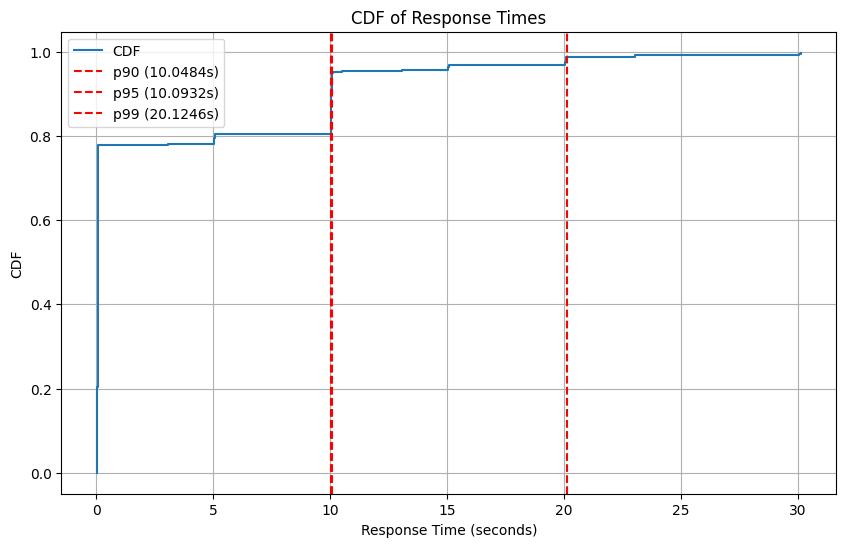

Script finished at Mon Mar 18 05:35:09 2024


In [5]:

#!/usr/bin/env python3

import os
import requests
import time
import numpy as np
import matplotlib.pyplot as plt

# Ming Chen, 25 July,2023
# Editing sending requests for bookinfo microservice app

# Getting the Gateway Url
INGRESS_PORT = os.popen(
    "kubectl -n istio-system get service istio-ingressgateway -o jsonpath=\"{.spec.ports[?(@.name=='http2')].nodePort}\""
).read().strip()
SECURE_INGRESS_PORT = os.popen(
    "kubectl -n istio-system get service istio-ingressgateway -o jsonpath=\"{.spec.ports[?(@.name=='https')].nodePort}\""
).read().strip()

INGRESS_HOST = os.popen(
    'kubectl get po -l istio=ingressgateway -n istio-system -o jsonpath="{.items[0].status.hostIP}"'
).read().strip()

GATEWAY_URL = f"http://{INGRESS_HOST}:{INGRESS_PORT}/productpage"

# Define the lambda parameter for the Poisson distribution
_lambda = 200 - 199

print("Starting script at", time.ctime())

# Collecting response times
response_times = []

for i in range(1, 501):
    start_time = time.time()
    response = requests.get(GATEWAY_URL)
    end_time = time.time()
    response_times.append(end_time - start_time)

    if i % 10 == 0:
        print("Sent", i, "requests so far...")

# Calculate percentiles
p50 = np.percentile(response_times, 50)
p90 = np.percentile(response_times, 90)
p95 = np.percentile(response_times, 95)
p99 = np.percentile(response_times, 99)

print(f"p50: {p50} seconds")
print(f"p90: {p90} seconds")
print(f"p95: {p95} seconds")
print(f"p99: {p99} seconds")

# Plotting the CDF
plt.figure(figsize=(10, 6))
sorted_data = np.sort(response_times)
plt.step(sorted_data, np.arange(sorted_data.size) / sorted_data.size, label='CDF', where='post')

# Highlight p90, p95, and p99 on the CDF plot
for percentile, value in [("p90", p90), ("p95", p95), ("p99", p99)]:
    plt.axvline(x=value, color='r', linestyle='--', label=f'{percentile} ({value:.4f}s)')

plt.xlabel('Response Time (seconds)')
plt.ylabel('CDF')
plt.title('CDF of Response Times')
plt.legend()
plt.grid(True)
plt.show()

print("Script finished at", time.ctime())
